In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Function to load and preprocess images
def load_images(directory):
    X = []
    y = []
    class_counts = {}  # Store the number of images loaded for each class
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = 0  # Initialize count for each class
            for image_file in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    # Resize image to a fixed size
                    image = cv2.resize(image, (128, 128))
                    if class_name in [] and class_counts[class_name] >= 300:
                        continue  # Skip if already loaded 300 images for 'cat', 'human', or 'dog'
                    X.append(image)
                    y.append(class_name)
                    class_counts[class_name] += 1

    X = np.array(X) / 255.0  # Normalize images
    y = np.array(y)
    
    # Print class-wise image counts
    print("Class-wise image counts:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

    return X, y

# Load images from directory
X, y = load_images('data/pneumonia')

Class-wise image counts:
NORMAL: 1341
PNEUMONIA: 3875


In [2]:
y.shape

(5216,)

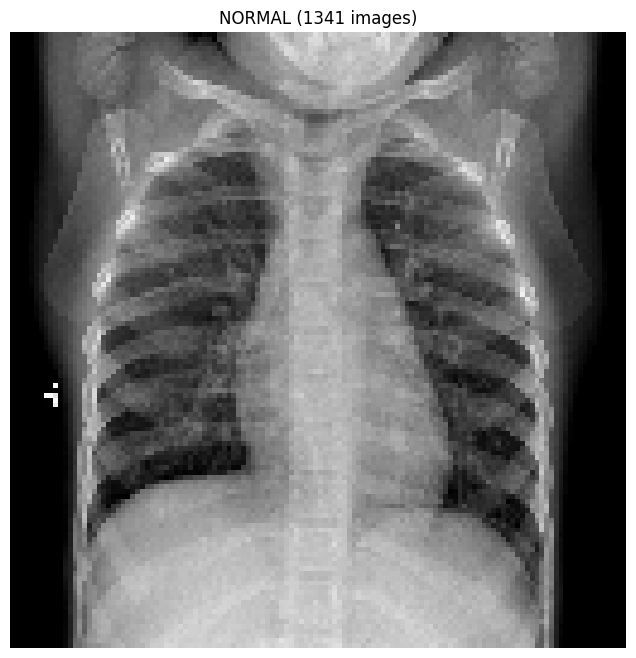

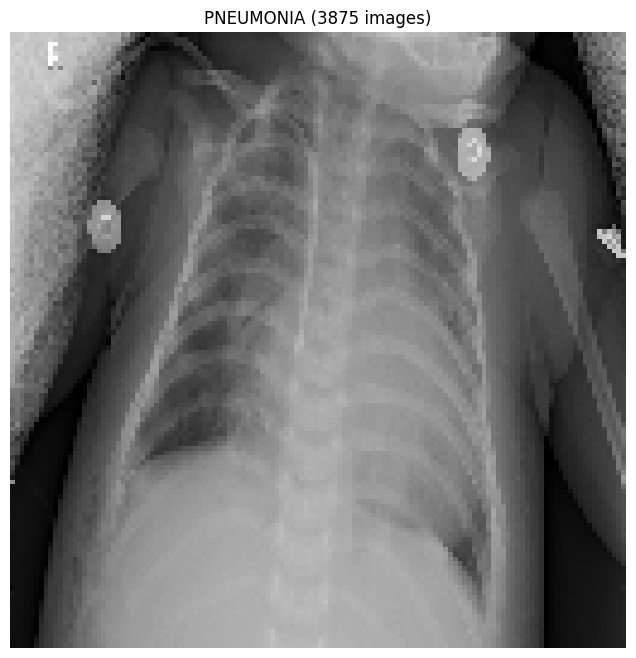

In [3]:
# Visualize one image from each class
unique_classes = np.unique(y)
import matplotlib.pyplot as plt

# Visualize one image from each class
unique_classes = np.unique(y)

for class_name in unique_classes:
    fig, ax = plt.subplots(figsize=(8, 8))

    class_indices = np.where(y == class_name)[0]
    sample_index = class_indices[0]
    sample_image = X[sample_index]

    ax.imshow(sample_image, cmap='gray')
    ax.set_title(f"{class_name} ({len(class_indices)} images)")
    ax.axis('off')

    plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder

# Encode y labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [7]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)


In [8]:
class SimpleANN:
    
    def __init__(self, input_size, hidden_size, output_size, activation='sigmoid'):
        self.weights_input_hidden = np.random.randn(input_size, hidden_size)
        self.bias_input_hidden = np.zeros((1, hidden_size))
        self.weights_hidden_output = np.random.randn(hidden_size, output_size)
        self.bias_hidden_output = np.zeros((1, output_size))
        self.activation = activation
        self.loss_history = []

    def forward(self, inputs):
        # Forward pass
        self.hidden_output = np.dot(inputs, self.weights_input_hidden) + self.bias_input_hidden
        if self.activation == 'sigmoid':
            self.hidden_activation = sigmoid(self.hidden_output)
        elif self.activation == 'relu':
            self.hidden_activation = relu(self.hidden_output)
        else:
            raise ValueError("Activation function not supported.")
        self.output = np.dot(self.hidden_activation, self.weights_hidden_output) + self.bias_hidden_output
        self.output_probs = softmax(self.output)
        return self.output_probs

    def backward(self, inputs, targets, learning_rate):
        # Backpropagation
        batch_size = inputs.shape[0]
        d_output = self.output_probs - targets
        d_weights_hidden_output = np.dot(self.hidden_activation.T, d_output) / batch_size
        d_bias_hidden_output = np.sum(d_output, axis=0, keepdims=True) / batch_size
        d_hidden_activation = np.dot(d_output, self.weights_hidden_output.T)
        if self.activation == 'sigmoid':
            d_hidden_output = d_hidden_activation * self.hidden_activation * (1 - self.hidden_activation)
        elif self.activation == 'relu':
            d_hidden_output = d_hidden_activation * (self.hidden_output > 0)
        else:
            raise ValueError("Activation function not supported.")
        d_weights_input_hidden = np.dot(inputs.T, d_hidden_output) / batch_size
        d_bias_input_hidden = np.sum(d_hidden_output, axis=0, keepdims=True) / batch_size

        # Update weights and biases
        self.weights_input_hidden -= learning_rate * d_weights_input_hidden
        self.bias_input_hidden -= learning_rate * d_bias_input_hidden
        self.weights_hidden_output -= learning_rate * d_weights_hidden_output
        self.bias_hidden_output -= learning_rate * d_bias_hidden_output

    def train(self, X_train, y_train, epochs, learning_rate):
        num_classes = len(np.unique(y_train))
        y_train_encoded = np.eye(num_classes)[y_train]

        for epoch in range(epochs):
            output = self.forward(X_train)
            self.backward(X_train, y_train_encoded, learning_rate)
            if epoch % 100 == 0:
                loss = -np.sum(y_train_encoded * np.log(output + 1e-9)) / len(y_train)
                self.loss_history.append(loss)
                print(f"Epoch {epoch}, Loss: {loss}")

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


In [15]:
# Create and train the model
model = SimpleANN(input_size=128*128, hidden_size=128, output_size=len(unique_classes), activation='relu')
model.train(X_train.reshape(-1, 128*128), y_train, epochs=1000, learning_rate=0.1)


Epoch 0, Loss: 7.886482555743443
Epoch 100, Loss: 0.37549329562742423
Epoch 200, Loss: 0.3297058387296974
Epoch 300, Loss: 0.3032187898448741
Epoch 400, Loss: 0.42005108408720365
Epoch 500, Loss: 0.2587578159407355
Epoch 600, Loss: 0.2580042881559013
Epoch 700, Loss: 0.2305847736544692
Epoch 800, Loss: 0.31205925869023865
Epoch 900, Loss: 0.2181753152468662


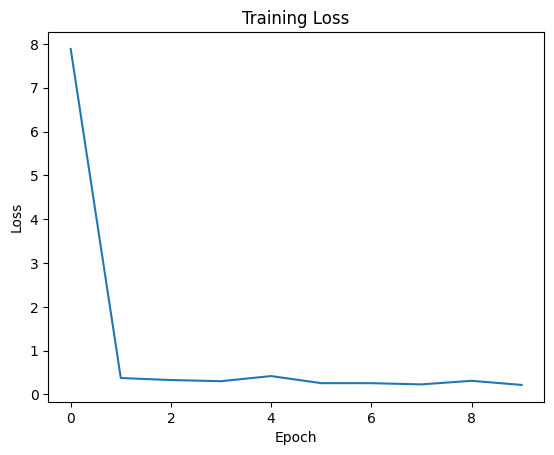

In [28]:
# Plotting Loss
plt.plot(range(len(model.loss_history)), model.loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [17]:
from sklearn.metrics import classification_report

# Testing
y_pred = model.predict(X_test.reshape(-1, 128*128))

# Classification Report
print(classification_report(y_test, y_pred))




              precision    recall  f1-score   support

           0       0.80      0.82      0.81       287
           1       0.93      0.92      0.93       757

    accuracy                           0.90      1044
   macro avg       0.87      0.87      0.87      1044
weighted avg       0.90      0.90      0.90      1044



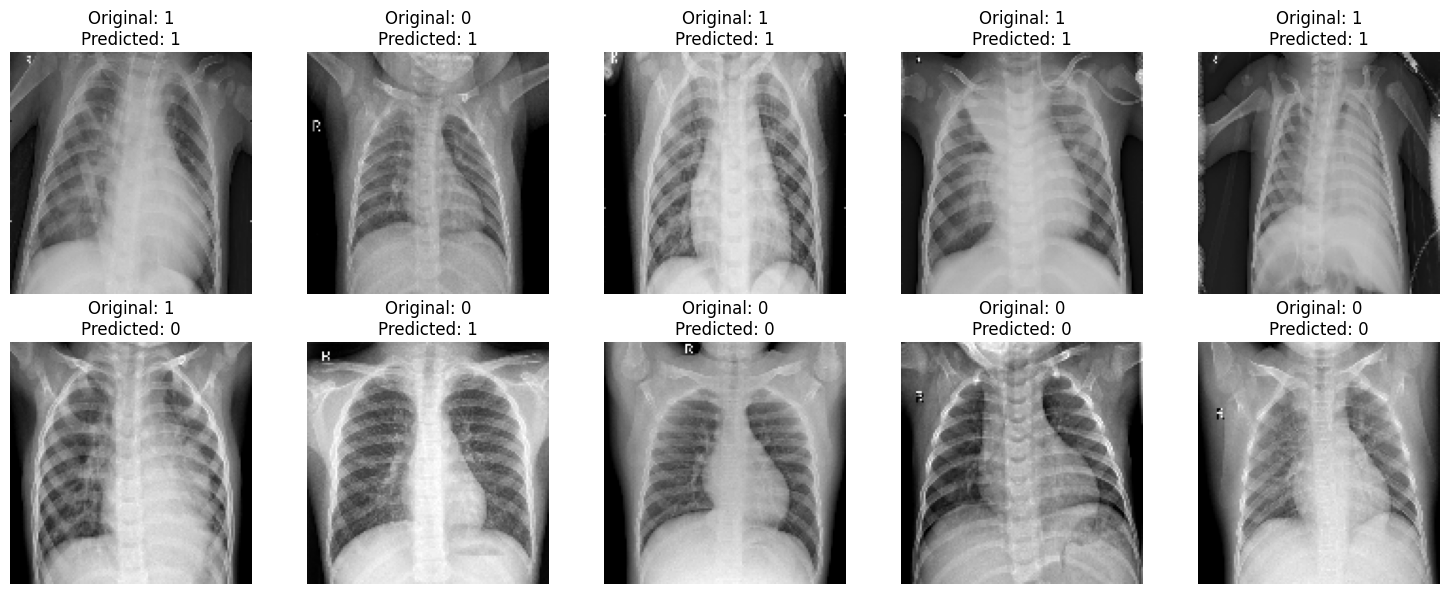

In [18]:
# Visualize test images with original and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(10):
    axs[i].imshow(X_test[i], cmap='gray')
    axs[i].set_title(f"Original: {y_test[i]}\nPredicted: {y_pred[i]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [23]:
import pickle

# Function to store the model
def save_model(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Function to load the model
def load_model(filename):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Function to predict the class of a given input image using a loaded model
def predict_image_class(model, image):
    # Preprocess the image (resize, grayscale, normalize)
    resized_image = cv2.resize(image, (128, 128))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    normalized_image = gray_image / 255.0  # Normalize to [0, 1]

    # Flatten the image
    flattened_image = normalized_image.reshape(1, -1)

    # Make prediction using the loaded model
    predicted_class_index = model.predict(flattened_image)

    # Reverse label encoding to get the class name
    predicted_class_name = label_encoder.inverse_transform(predicted_class_index)[0]

    return predicted_class_index[0]


In [24]:
# Save the trained model
save_model(model, 'models/image_classifier_using_mlp.pkl')

# Load the model
loaded_model = load_model('models/image_classifier_using_mlp.pkl')

# Use the loaded model to predict the class of a given input image
input_image = cv2.imread('data/pneumonia/PNEUMONIA/person1_bacteria_1.jpeg')  # Replace 'input_image.jpg' with the path to your input image
predicted_class = predict_image_class(loaded_model, input_image)
print("Predicted class:", predicted_class)


Predicted class: 1
